# Interactive Map
This notebook documents making an interactive station/event map using
the `folium` module

In [4]:
import folium
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
import contextily as cx

# Define small helper functions
m2deg = lambda x:x/111139.
km2mi = lambda x:x*1e3*3.281/5280.

In [6]:
# Initialize Client
client = Client('IRIS')

# Define fields for query
fields = ('starttime','endtime','latitude','longitude','maxradius')
TSstr = "2017-01-01T00:00:00"
TEstr = "2018-01-01T00:00:00"
lat0,lon0 = 47.5828,-122.57841
# Define data selection kwargs for stations in IRIS catalog
qstation_kwargs = dict(zip(fields,[UTCDateTime(TSstr),\
                                   UTCDateTime(TEstr),\
                                   lat0,lon0,m2deg(30e3)]))

# Limit channels to those coming from broadbands ?H? and accelerometers ?N?
CLIST = 'HHZ,HHN,HH1,HHE,HH2,ENZ,EN1,ENN,EN2,ENE,BHZ,BHN,BHZ,EHZ,EH1,EHN,EH2,EHE'


inv = client.get_stations(**qstation_kwargs,level='channel',channel=CLIST)#,channel='??[ZNE12]')
print(inv.networks[-1])

Network UW (Pacific Northwest Seismic Network (PNSN))
	Station Count: 36/860 (Selected/Total)
	1963-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (36):
			UW.ALKI (Alki Wastewater Plant, Seattle, WA, USA)
			UW.BABE (Bainbridge, WA, USA)
			UW.BES3 (Bremerton Swarm Portable 3, WA, USA)
			UW.BES4 (Bremerton Swarm Portable 4, WA, USA)
			UW.BES5 (Bremerton Swarm Portable 5, WA, USA)
			UW.BRKS (Brookside, WA, USA)
			UW.BSFP (Boeing Fire Protection, WA, USA)
			UW.GMW (Gold Mountain, WA, USA)
			UW.GNW (Green Mountain, WA, USA)
			UW.GTWN (Georgetown Playfield ANSS-SMO)
			UW.HART (Harbor Island, Seattle, WA, USA)
			UW.HOLY (Holy Rosary ANSS-SMO)
			UW.KCAM (King County Airport Maintenance Shop, Seattle, WA, USA)
			UW.KDK (Kingdome, Seattle, WA, USA)
			UW.KIMB (Kimball School, Seattle, WA, USA)
			UW.KIMR (Kitsap County HHW Collection Facility, Bremerton, WA, USA)
			UW.KINR (North Road Shop, Poulsbo, WA, USA)
			UW.KITP (Kitsap Treatment Plant, WA, USA)
			UW.LAWT 

In [7]:
# Define data selection kwargs for events from IRIS catalog
qevent_kwargs = dict(zip(fields,[UTCDateTime(TSstr),\
                                UTCDateTime(TEstr),\
                                lat0,lon0,m2deg(1e4)]))

# Download catalog from Client
cat = client.get_events(**qevent_kwargs,includearrivals=True,includeallmagnitudes=True,includeallorigins=True)
# print(cat.__str__(print_all=True))

# cat.plot()
# Do basic extraction to dataframe matching PNSN query output format
fields = ['Evid','Magnitude','Magnitude Type','Epoch(UTC)',\
          'Time UTC','Time Local','Distance From','Lat','Lon',\
          'Depth Km','Depth Mi']
holder =[]; index = []
for e_ in cat.events:
    Evid = int(e_.resource_id.id.split('=')[-1])
    for m_ in e_.magnitudes:
        if m_.resource_id == e_.preferred_magnitude_id:
            Mag = float(m_.mag)
            MagType = m_.magnitude_type[-1]
    for o_ in e_.origins:
        if o_.resource_id == e_.preferred_origin_id:
            Epoch = o_.time.timestamp
            tUTC = pd.Timestamp(Epoch*1e9)
            tLOC = tUTC - pd.Timedelta(7,unit='hour')
            dFROM = ''
            Lat = o_.latitude
            Lon = o_.longitude
            zKm = o_.depth*1e-3
            zMi = km2mi(zKm)
    index.append(tUTC)
    line = [Evid,Mag,MagType,Epoch,tUTC,tLOC,dFROM,Lat,Lon,zKm,zMi]
    holder.append(line)

df_EVE = pd.DataFrame(holder,columns=fields,index=index)
df_EVE.sort_index()
display(df_EVE)

,Evid,Magnitude,Magnitude Type,Epoch(UTC),Time UTC,Time Local,Distance From,Lat,Lon,Depth Km,Depth Mi
2017-12-31 18:43:40.689999872,10599796,1.93,l,1.514746e+09,2017-12-31 18:43:40.689999872,2017-12-31 11:43:40.689999872,,47.587167,-122.579333,21.95,13.639763
2017-12-18 23:57:10.969999872,10565357,0.58,l,1.513641e+09,2017-12-18 23:57:10.969999872,2017-12-18 16:57:10.969999872,,47.645667,-122.641333,4.74,2.945443
2017-11-22 16:22:28.809999872,10556793,2.20,l,1.511368e+09,2017-11-22 16:22:28.809999872,2017-11-22 09:22:28.809999872,,47.593500,-122.562833,22.10,13.732973
2017-11-04 09:52:41.350000128,10452436,1.09,l,1.509789e+09,2017-11-04 09:52:41.350000128,2017-11-04 02:52:41.350000128,,47.600167,-122.558167,18.54,11.520784
2017-11-01 07:38:51.700000000,10450892,1.33,l,1.509522e+09,2017-11-01 07:38:51.700000000,2017-11-01 00:38:51.700000000,,47.635333,-122.591500,22.83,14.186597
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-25 14:03:57.320000000,9994944,0.20,d,1.485353e+09,2017-01-25 14:03:57.320000000,2017-01-25 07:03:57.320000000,,47.571500,-122.495500,8.31,5.163847
2017-01-25 14:03:20.620000000,9994937,0.87,l,1.485353e+09,2017-01-25 14:03:20.620000000,2017-01-25 07:03:20.620000000,,47.527667,-122.631667,22.66,14.080958
2017-01-24 21:11:54.440000000,9994694,1.31,d,1.485292e+09,2017-01-24 21:11:54.440000000,2017-01-24 14:11:54.440000000,,47.507667,-122.646500,-0.43,-0.267203
2017-01-24 18:46:16.009999872,9994626,0.86,l,1.485284e+09,2017-01-24 18:46:16.009999872,2017-01-24 11:46:16.009999872,,47.532667,-122.668833,16.25,10.097775


In [8]:
# Compile station locations 
sta_llh = []
for N_ in inv.networks:
    for S_ in N_.stations:
        sta_llh.append([N_.code,S_.code,S_.latitude,S_.longitude,S_.elevation,S_.channels[0].code[:2]])

df_STA = pd.DataFrame(sta_llh,columns=['network','station','latitude','longitude','elevation','Band/Inst Code'])


In [9]:
# Generate GeoDataFrames from df_STA and df_EVE
gdf_STA = geopandas.GeoDataFrame(df_STA,geometry=geopandas.points_from_xy(df_STA.latitude,df_STA.longitude),crs="EPSG:4326")

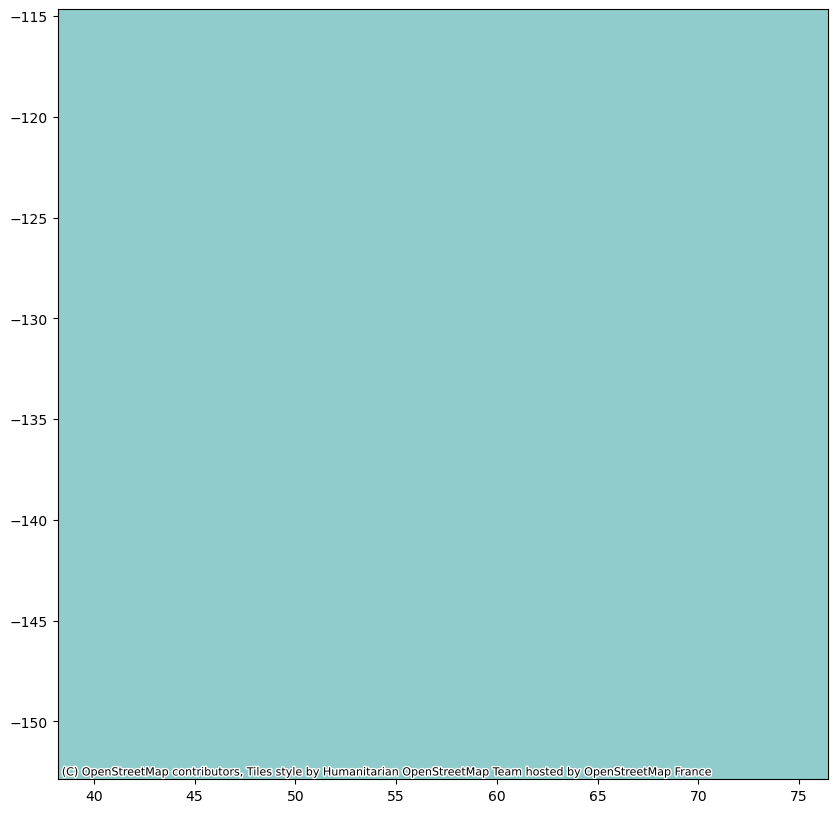

In [19]:
# fig, ax = plt.subplots(figsize=(10,10))
# img,ext = cx.bounds2img(lat0 - 3, lon0 - 3, lat0 + 3, lon0 + 3, zoom = 20,source=cx.providers.Stamen.Toner)
# ax.axis(ext)
# cx.add_basemap(ax)

In [30]:
## GENERATE FOLIUM MAP ##
# Initialize map centered on the Bremerton swarm
map = folium.Map(location=[lat0,lon0],zoom_start=10)

ll_sta = df_STA[['latitude','longitude']].values
for coord in ll_sta:
    # print(coord)
    map.add_child(folium.CircleMarker(location=[coord[0],coord[1]],radius=2))

map
# Add stations, using different markerstyles
# plt.scatter(df_STA['longitude'],df_STA['latitude'])